In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, transpile
from qiskit.circuit import Gate, Parameter

from rttgen import PulseEfficientCR, CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step_no_opt, single_step, two_steps
from observables import plot_counts_with_curve

In [2]:
nsites = 4

aJ = 0.5 # Hamiltonian J parameter
am = 0.25 # Hamiltonian mu parameter

M = 30 # number of Trotter steps
omegadt = np.pi / 30 # Trotter step size

In [3]:
backend = Aer.get_backend('qasm_simulator')
physical_qubits = None

In [4]:
rtts_cnot = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in [(0, 1), (1, 2), (2, 3)])
cxs = {(0, 1): cx_circuit(backend, 0, 1), (1, 0): cx_circuit(backend, 1, 0)}

In [5]:
def trotter_step_circuits(rtts=None, cxs=None, optimization_level=1, use_opt=False, combine_two_steps=True):
    if rtts or use_opt:
        single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts, cxs=cxs)
        two_step_circuit = two_steps(nsites, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    else:
        single_step_circuit = single_step_no_opt(nsites, aJ, am, omegadt)
        two_step_circuit = single_step_circuit.compose(single_step_circuit)
    
    circuits = []
    for nrep in range(1, M + 1):
        circuit = QuantumCircuit(nsites, nsites)
        circuit.x(0)
        circuit.x(2)

        for _ in range(nrep // 2):
            if combine_two_steps:
                circuit.compose(two_step_circuit, inplace=True)
            else:
                circuit.compose(single_step_circuit, inplace=True)
                circuit.compose(single_step_circuit, inplace=True)
                
        if nrep % 2 == 1:
            circuit.compose(single_step_circuit, inplace=True)
            
        circuit.measure(circuit.qregs[0], circuit.cregs[0])
        circuits.append(circuit)
    
    circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=optimization_level)
    
    return circuits

In [6]:
def combined_and_corrected_counts(job, exp_block_size):
    raw_counts = job.result().get_counts()
    counts = raw_counts[:exp_block_size]
    for iexp, cdict in enumerate(raw_counts[exp_block_size:]):
        ic = iexp % exp_block_size
        for key, value in cdict.items():
            try:
                counts[ic][key] += value
            except KeyError:
                counts[ic][key] = value

    return counts

## Define and submit all circuits

naive 9bfbd681-9822-4674-be97-3ff9cb56da2a


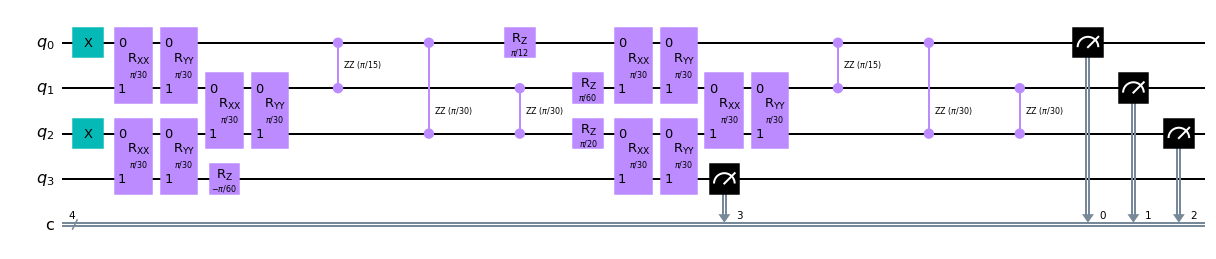

In [7]:
circuits = trotter_step_circuits(optimization_level=3)
job_naive = backend.run(circuits, shots=10000)
print('naive', job_naive.job_id())
circuits[1].draw('mpl', idle_wires=False)

cnot 29398cc5-46f9-4607-8a3d-273353434bdb


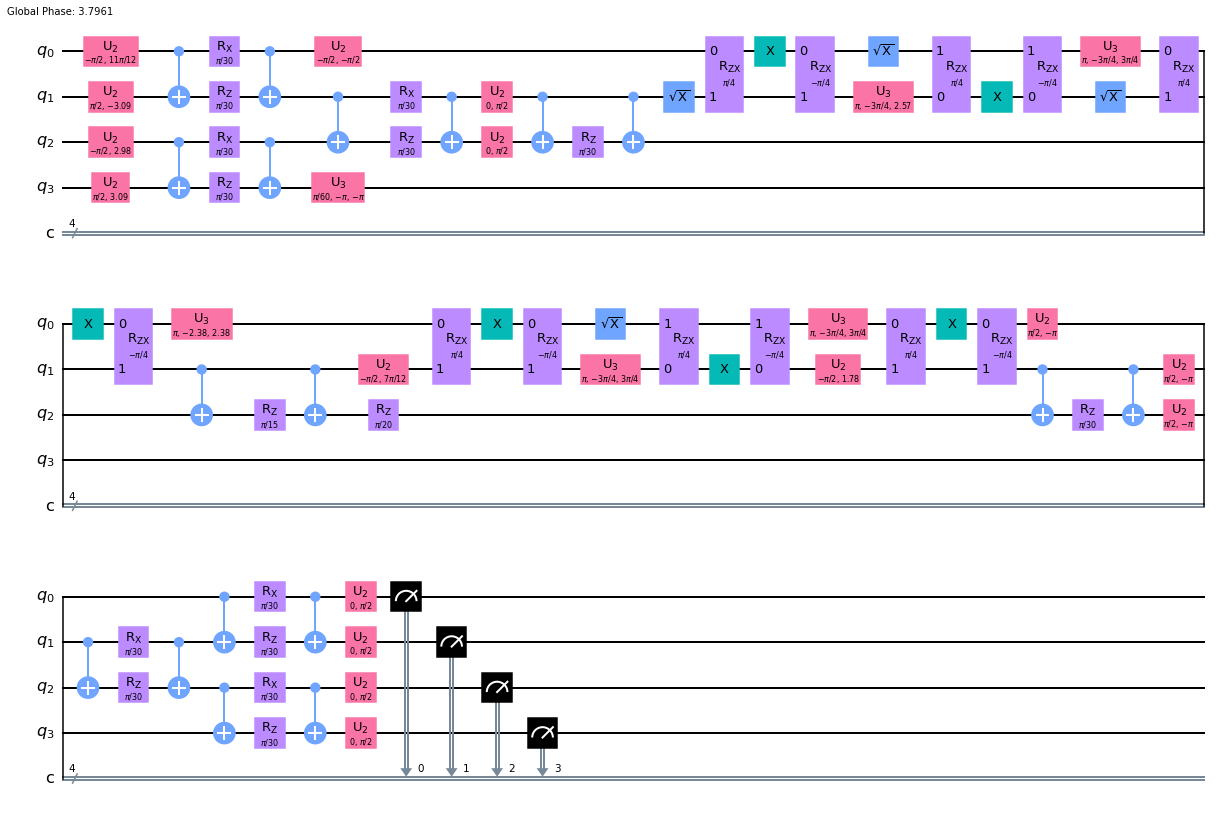

In [8]:
circuits = trotter_step_circuits(rtts=rtts_cnot, cxs=cxs)
job_cnot = backend.run(circuits, shots=10000)
print('cnot', job_cnot.job_id())
circuits[1].draw('mpl', idle_wires=False)

cnot_single d5316829-d852-4390-a3f4-5487cee6194d


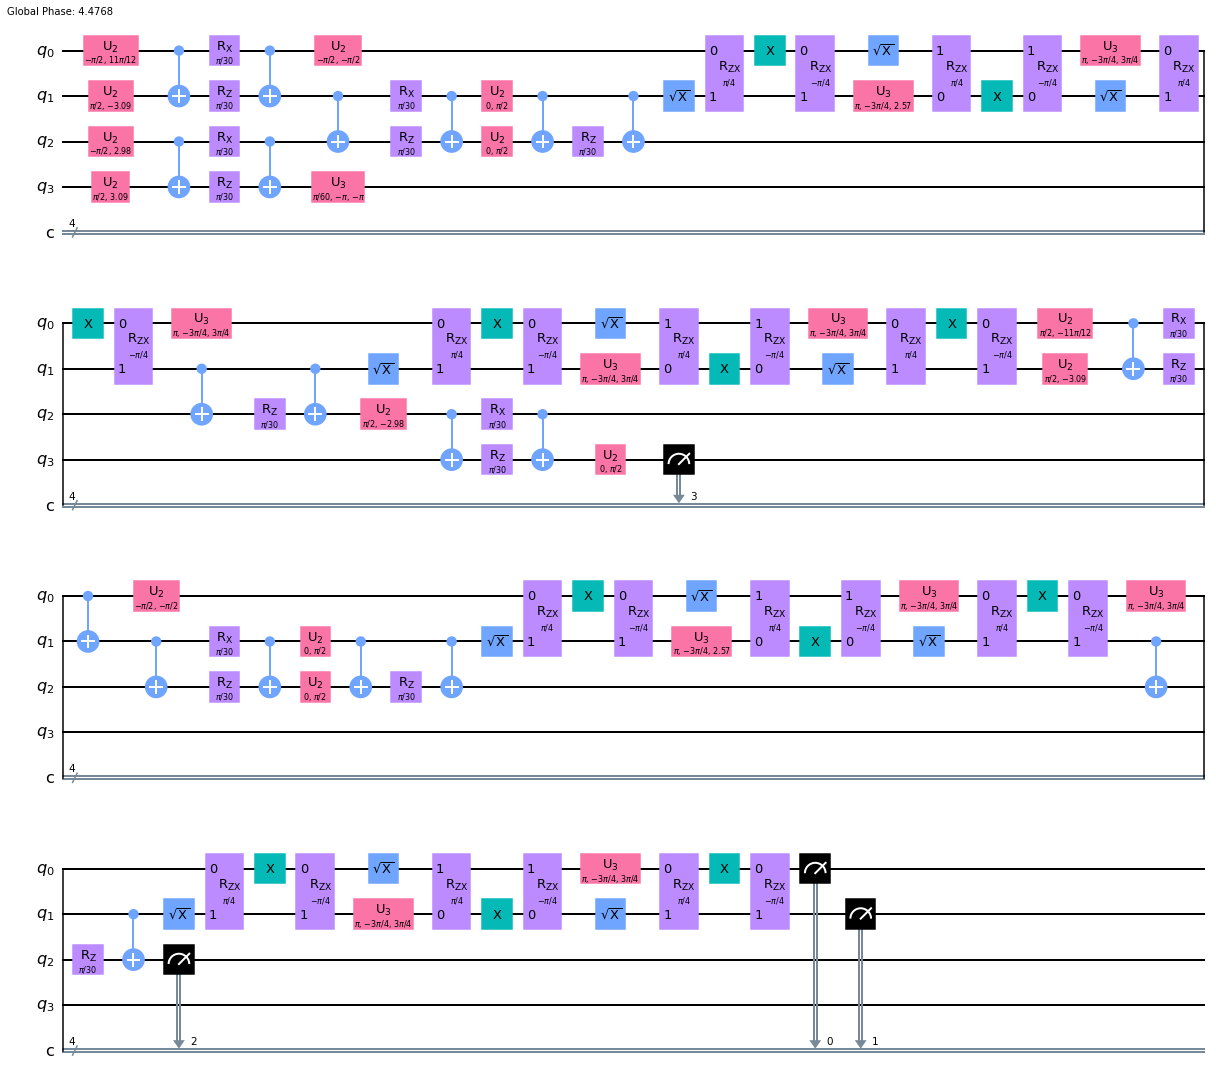

In [9]:
circuits = trotter_step_circuits(rtts=rtts_cnot, cxs=cxs, combine_two_steps=False)
job_cnot_single = backend.run(circuits, shots=10000)
print('cnot_single', job_cnot_single.job_id())
circuits[1].draw('mpl', idle_wires=False)

## Naive circuit (optimization level 3)

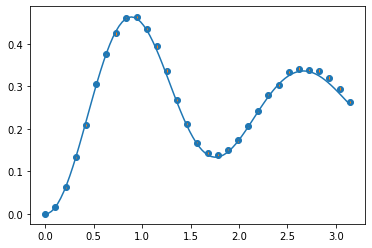

In [10]:
plot_counts_with_curve(combined_and_corrected_counts(job_naive, M), nsites, aJ, am, omegadt, M)

## Optimized circuit with CNOT-based Rtt

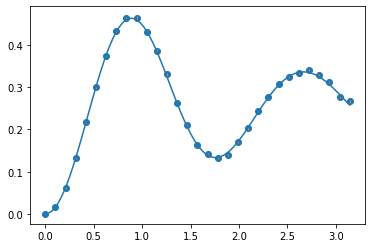

In [11]:
plot_counts_with_curve(combined_and_corrected_counts(job_cnot, M), nsites, aJ, am, omegadt, M)

## Optimized circuit with CNOT-based Rtt, all single steps

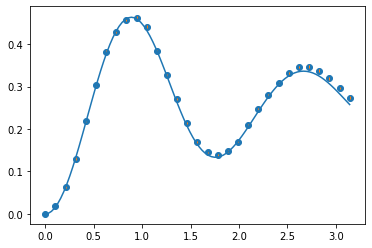

In [12]:
plot_counts_with_curve(combined_and_corrected_counts(job_cnot_single, M), nsites, aJ, am, omegadt, M)